In [27]:
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math

## Load and Normalize Data
To compute the spectral efficiency, both transmitter and receiver should be optimized with NN. So the dataset contains F_opt and W_opt.

In [28]:
train_layouts = 10000
test_layouts = 2000

In [29]:
data = scipy.io.loadmat('hb_train_144_36.mat')
Fopt_train = data['Fopt'].transpose(2,0,1)
Wopt_train = data['Wopt'].transpose(2,0,1)

In [30]:
test_data = scipy.io.loadmat('hb_test_144_36.mat')
Fopt_test = test_data['Fopt'].transpose(2,0,1)
Wopt_test = test_data['Wopt'].transpose(2,0,1)

In [32]:
Fopt_train.shape,Wopt_train.shape

((10000, 144, 2), (10000, 36, 2))

In [33]:
def normalize_data(train_data,test_data):
    n1, n2 = train_data.shape[0], test_data.shape[0]
    norm_train = train_data.reshape(n1,-1)
    norm_test = test_data.reshape(n2,-1)
    
    norm_train = np.concatenate((norm_train.real, norm_train.imag),axis = 1)
    norm_test = np.concatenate((norm_test.real, norm_test.imag),axis = 1)
    return norm_train, norm_test
norm_train_F, norm_test_F = normalize_data(Fopt_train, Fopt_test)
norm_train_W, norm_test_W = normalize_data(Wopt_train, Wopt_test)

## Create Dataset

In [13]:
class PCDataset(torch.utils.data.Dataset):
    def __init__(self, data_F, F_opt, data_W, W_opt):
        'Initialization'
        self.Fdata = torch.tensor(data_F, dtype = torch.float)
        self.F_opt = torch.tensor(F_opt, dtype = torch.cfloat)
        self.Wdata = torch.tensor(data_W, dtype = torch.float)
        self.W_opt = torch.tensor(W_opt, dtype = torch.cfloat)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.Fdata)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        F = self.Fdata[index]
        F_opt = self.F_opt[index]
        W = self.Wdata[index]
        W_opt = self.W_opt[index]
        return F, F_opt, W, W_opt

In [34]:
train_data = PCDataset(norm_train_F, Fopt_train, norm_train_W, Wopt_train)
test_data = PCDataset(norm_test_F, Fopt_test, norm_test_W, Wopt_test)

In [35]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, test_layouts, shuffle=False)

## Build Model

#### Loss function
As the phase shifter matrix is block diagonal, we first define a block diagonal mask

In [203]:
N_r, N_t, N_RF, N_s = Wopt_train.shape[1], Fopt_train.shape[1], 3, Fopt_train.shape[2]
Fmask = np.zeros((1,N_t, N_RF) )
Wmask = np.zeros((1,N_r, N_RF) )
for i in range(N_RF):
    Fmask[0,i*N_t//N_RF: (i+1)*N_t//N_RF,i] = np.ones((N_t//N_RF) )
    Wmask[0,i*N_r//N_RF: (i+1)*N_r//N_RF,i] = np.ones((N_r//N_RF) )
Fmask = torch.tensor(Fmask, dtype = torch.cfloat)
Wmask = torch.tensor(Wmask, dtype = torch.cfloat)

The neural network module only needs to output F_BB and W_BB. F_RF and W_RF can be obtained by using (33) in [1].

Note: New version pytorch supports complex valued auto differentiation. Please refer to https://pytorch.org/docs/stable/complex_numbers.html for details. 

In [204]:
def FMF_loss(F_BB, F_opt):
    # Compute F_RF from F_BB
    F_BB = F_BB/torch.norm(F_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    F_RF = F_opt @ F_BB.conj().transpose(1,2)
    F_RF = F_RF/torch.abs(F_RF)
    F_RF = Fmask * F_RF / math.sqrt(N_t)
    # Matrix factorization loss
    return torch.mean(torch.norm(F_opt - F_RF @ F_BB, dim = [1,2])**2)

In [205]:
def WMF_loss(W_BB, W_opt):
    # Compute W_RF from W_BB
    W_BB = W_BB/torch.norm(W_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    W_RF = W_opt @ W_BB.conj().transpose(1,2)
    W_RF = W_RF/torch.abs(W_RF)
    W_RF = Wmask * W_RF / math.sqrt(N_r)
    # Matrix factorization loss
    return torch.mean(torch.norm(W_opt - W_RF @ W_BB, dim = [1,2])**2)

#### Standard MLP modules

In [206]:
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

In [207]:
# FNet maps F_opt to F_BB
class FNet(torch.nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.out_dim = N_RF*N_s
        self.mlp = MLP([N_t * N_s * 2, 100, 100])
        self.mlp = Seq(*[self.mlp,Seq(Lin(100, 2*N_RF*N_s))])

    def forward(self, data):
        bs = data.shape[0]
        out = self.mlp(data)
        out_real = torch.unsqueeze(out[:, :self.out_dim], axis = -1)
        out_imag = torch.unsqueeze(out[:, self.out_dim:self.out_dim*2], axis = -1)
        out = torch.cat((out_real, out_imag), axis = -1)
        out = torch.view_as_complex(out)
        return out.reshape((bs,N_RF,N_s))

In [208]:
# WNet maps W_opt to W_BB
class WNet(torch.nn.Module):
    def __init__(self):
        super(WNet, self).__init__()
        self.out_dim = N_RF*N_s
        self.mlp = MLP([N_r * N_s * 2, 100, 100])
        self.mlp = Seq(*[self.mlp,Seq(Lin(100, 2*N_RF*N_s))])

    def forward(self, data):
        bs = data.shape[0]
        out = self.mlp(data)
        out_real = torch.unsqueeze(out[:, :self.out_dim], axis = -1)
        out_imag = torch.unsqueeze(out[:, self.out_dim:self.out_dim*2], axis = -1)
        out = torch.cat((out_real, out_imag), axis = -1)
        out = torch.view_as_complex(out)
        return out.reshape((bs,N_RF,N_s))

## Train and Test

In [209]:
def train(epoch):
    """ Train for one epoch. """
    Fmodel.train()
    Wmodel.train()
    loss_all = 0
    for batch_idx, (F_train, F_opt_train, W_train, W_opt_train) in enumerate(train_loader):
        #data = data.to(device)
        optimizer.zero_grad()
        Foutput = Fmodel(F_train)
        Woutput = Wmodel(W_train)
        loss = FMF_loss(Foutput, F_opt_train) + WMF_loss(Woutput, W_opt_train)
        loss.backward()
        loss_all += loss.item() * len(F_train)
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [210]:
def test(loader):
    Fmodel.eval()
    Wmodel.eval()
    correct = 0
    for (F_test, F_opt_test, W_test, W_opt_test) in loader:
        #data = data.to(device)
        Foutput = Fmodel(F_test)
        Woutput = Wmodel(W_test)
        loss = FMF_loss(Foutput, F_opt_test) + WMF_loss(Woutput, W_opt_test)
        correct += loss.item() * len(F_test)
    return correct / len(loader.dataset)

In [211]:
Fmodel = FNet()
Wmodel = WNet()
optimizer = torch.optim.Adam(list(Fmodel.parameters()) + list(Wmodel.parameters()), lr=1e-3)

In [212]:
record = []
for epoch in range(0, 200):
    train_rate = test(train_loader)
    test_rate = test(test_loader)
    if(epoch % 10 == 0):
        print('Epoch {:03d}, Train Rate: {:.4f}, Test Rate: {:.4f}'.format(
            epoch, train_rate, test_rate))
    record.append([train_rate, test_rate])
    train(epoch)

Epoch 000, Train Rate: 3.0949, Test Rate: 3.0898
Epoch 010, Train Rate: 2.2889, Test Rate: 2.5351
Epoch 020, Train Rate: 2.2187, Test Rate: 2.5291
Epoch 030, Train Rate: 2.1873, Test Rate: 2.5325
Epoch 040, Train Rate: 2.1688, Test Rate: 2.5344
Epoch 050, Train Rate: 2.1568, Test Rate: 2.5359
Epoch 060, Train Rate: 2.1438, Test Rate: 2.5402
Epoch 070, Train Rate: 2.1368, Test Rate: 2.5397
Epoch 080, Train Rate: 2.1308, Test Rate: 2.5436
Epoch 090, Train Rate: 2.1276, Test Rate: 2.5414
Epoch 100, Train Rate: 2.1222, Test Rate: 2.5432
Epoch 110, Train Rate: 2.1168, Test Rate: 2.5492
Epoch 120, Train Rate: 2.1145, Test Rate: 2.5450
Epoch 130, Train Rate: 2.1110, Test Rate: 2.5464
Epoch 140, Train Rate: 2.1085, Test Rate: 2.5474
Epoch 150, Train Rate: 2.1060, Test Rate: 2.5481
Epoch 160, Train Rate: 2.1046, Test Rate: 2.5474
Epoch 170, Train Rate: 2.1039, Test Rate: 2.5474
Epoch 180, Train Rate: 2.1007, Test Rate: 2.5482
Epoch 190, Train Rate: 2.0994, Test Rate: 2.5504


## Plots

In [213]:
import matplotlib.pyplot as plt

train_losses=[record[i][0] for i in range(len(record))]
test_losses=[record[i][1] for i in range(len(record))]

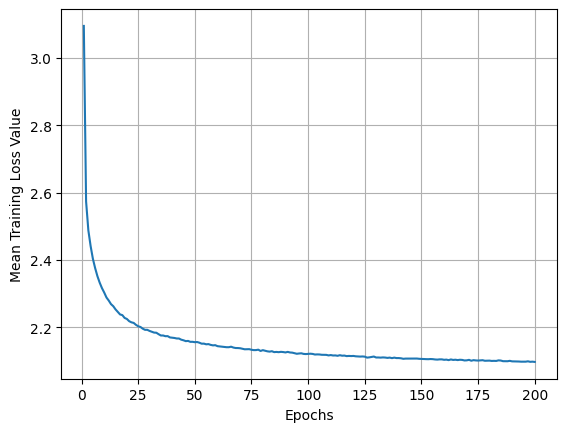

In [214]:
plt.plot(np.arange(len(record))+1,train_losses)
plt.title("")
plt.xlabel('Epochs')
plt.ylabel('Mean Training Loss Value')
plt.grid(True)
plt.show()

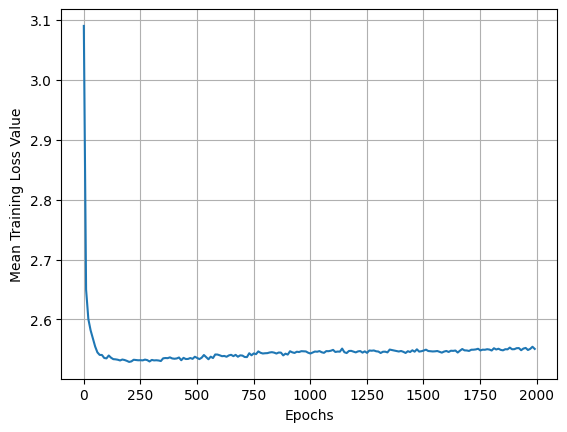

In [215]:
plt.plot(10*np.arange(len(record))+1,test_losses)
plt.xlabel('Epochs')
plt.ylabel('Mean Training Loss Value')
plt.grid(True)
plt.show()

## Compute spectral efficiency
The rate computation function is from [1] https://github.com/yuxianghao/Alternating-minimization-algorithms-for-hybrid-precoding-in-millimeter-wave-MIMO-systems/blob/Initial/Narrowband/SDR-AltMin/main_SNR.m

In [216]:
def FBB2FRF(F_BB, F_opt):
    F_BB = F_BB/torch.norm(F_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    F_RF = F_opt @ F_BB.conj().transpose(1,2)
    F_RF = F_RF/torch.abs(F_RF)
    F_RF = Fmask * F_RF / math.sqrt(N_t)
    return F_BB, F_RF

def WBB2WRF(W_BB, W_opt):
    W_BB = W_BB/torch.norm(W_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    W_RF = W_opt @ W_BB.conj().transpose(1,2)
    W_RF = W_RF/torch.abs(W_RF)
    W_RF = Wmask * W_RF / math.sqrt(N_r)
    return W_BB, W_RF

def compute_rate(FBB, FRF, WBB, WRF, H, SNR):
    '''Matlab code: log2(det(eye(Ns) + SNR(s)/Ns * pinv(WRF * WBB) * H(:,:,reali) * FRF * FBB * FBB' * FRF' * H(:,:,reali)' * WRF * WBB))
    '''
    rate = torch.log2(torch.det(torch.eye(N_s) + SNR/N_s * torch.linalg.pinv(WRF @ WBB) @ H @ FRF @ FBB @ FBB.conj().transpose(1,2)
                                         @ FRF.conj().transpose(1,2) @ H.conj().transpose(1,2) @ WRF @ WBB))
    return float(torch.mean(rate).detach().numpy().real)

def rate_test(loader, H):
    Fmodel.eval()
    Wmodel.eval()
    correct = 0
    with torch.no_grad():
        for (F_test, F_opt, W_test, W_opt) in loader:
            #data = data.to(device)
            FBB = Fmodel(F_test)
            FBB, FRF = FBB2FRF(FBB, F_opt)
            WBB = Wmodel(W_test)
            WBB, WRF = WBB2WRF(WBB, W_opt)
            
            print('MF loss:', WMF_loss(WBB, W_opt) + FMF_loss(FBB, F_opt))

        SNR_dBs = np.arange(-15, 15, 5)
        res_mlp = []
        res_opt = []
        res_ran = []
        for SNR_dB in SNR_dBs:
            SNR = 10**(SNR_dB/10)
            res_mlp.append(compute_rate(FBB, FRF, WBB, WRF, H, SNR))
    return res_mlp

In [221]:
test_data = scipy.io.loadmat('hb_test_144_36.mat')
H = torch.tensor(test_data['H'].transpose(2,0,1), dtype = torch.cfloat)

In [224]:
import time

tic=time.time()
res_mlp=rate_test(test_loader, H)
toc=time.time()

print((toc-tic)/2000)

MF loss: tensor(2.5536)
8.224654197692871e-05


In [225]:
print(list(range(-15,15,5)))
print(res_mlp)

[-15, -10, -5, 0, 5, 10]
[4.84113883972168, 7.5228271484375, 10.561134338378906, 13.773470878601074, 17.056568145751953, 20.365428924560547]


In [220]:
test_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fopt', 'H', 'Wopt'])

## References
[1] X. Yu, J.-C. Shen, J. Zhang, and K. B. Letaief, “Alternating minimization algorithms for hybrid precoding in millimeter wave mimo systems,” IEEE J. Sel. Topics Signal Process., vol. 10, no. 3, pp. 485–500, 2016